# ADA Project
<br><br>

----
### Subject: 
finding what influence the number of protests among: area of the country, population density, net migration, infant mortality, deathrate, income group, climate, etc.  
<br><br>

----
### Objective: 
finding what to change in a country to decrease the number of protests (assuming that a less number of protests means that the inhabitants are happier)
<br><br>

----
### Summary:
First, we will get all the data we need. Second we will find a way to display data on a world map to visualize the number of protests around the world. Then, we will try to find the impact of many variables on this number of protests.
<br><br>

----
### Data explanations:
Please see the read me, section Dataset / 4- Data description to see data explanations

Here a brief explanation:

We are using the data available at the following link: https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events This is a context of **big data**: around **400 000 000** of rows.
<br><br>
- ##### <u>eventcodes.csv</u>

As we are interested in protest as kind of event, we need to find the event code associated to the protest events: **eventcodes.csv** gives us this data.
<br><br>
- ##### <u>country_by_income.csv and countries_stats.csv</u>

Then, we need to get data on all the countries to find the impact of their characteristics on the number of protests: **country_by_income.csv** and **countries_stats.csv** give us what we need. Thanks to these files, we have access to: the average income, area of the country, population density, net migration, infant mortality, deathrate, climate, etc of each country.
Got from: http://datatopics.worldbank.org/world-development-indicators/the-world-by-income-and-region.html and https://www.kaggle.com/fernandol/countries-of-the-world/version/1

<br><br>
Let's see the **countries_stats.csv** file:

data got from: https://www.kaggle.com/fernandol/countries-of-the-world/version/1

Data available: `Country`, `Region`, `Population`, `Area (sq. mi.)`, `Pop. Density (per sq. mi.)`, `Coastline (coast/area ratio)`, `Net migration`, `Infant mortality (per 1000 births)`, `GDP ($ per capita)`, `Literacy (%)`, `Phones (per 1000)`, `Arable (%)`, `Crops (%)`, `Other (%)`, `Climate`, `Birthrate`, `Deathrate`, `Agriculture`, `Industry`, `Service`.

Most of the variables don't need to be explain as `population`, `Area (sq. mi.)`, `Infant mortality`, etc. As we wordered the meaning of `climate`, here the explanation we found:

Meaning of `climate`: 1= Dry tropical, 2= Wet tropical, 3= Temperate humid subtropical and temperate continental, 4= Dry hot summers and wet winters
<br><br>
- ##### <u>country_codes_iso2_to_iso3.csv and country_code_to_name.csv</u>

Each data define the country in a different way: code in `ISO2` or `ISO3` or with the `country name`. We need to convert each ones with the same convention. For example, to define the United-States of America, the csv files use "USA", "US" or "United-States of America". 
**country_codes_iso2_to_iso3.csv** and **country_code_to_name.csv** allow us to achieve these conversions.
there are from: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
<br><br>

- ##### <u>GDP growth world bank.csv and GINI per country worldbank.csv</u> (<a> https://data.worldbank.org </a>)
These two dataset are the estimations of the Gross Domestic Product (GDP) and the Index of Inequality (GINI) for each country , from 1960 to 2017. These datasets will be usefull economical and social indicator to understand the protestation in different countries.
(Higher index is better)

- ##### <u>DataCorruptionPerceptionIndex2000_2017.xlsx</u> (<a>https://www.transparency.org</a>)
This data set shows the estimated Corruption index (political and buisness corruption) for each country from 2000 to 2017. 
(Lower index is better)

- ##### <u>Human Development Index (HDI).csv</u> (<a> http://hdr.undp.org/en/data </a>)
Dataset of the HDI for each country from 1990 to 2017.
HDI a good indicator of the life expectancy and education of people in the country.
The definition of HDI from wikipedia:
"The Human Development Index (HDI) is a statistic composite index of life expectancy, education, and per capita income indicators"
(Higher index is better)



- ##### <u>World press freedom.csv
</u> (<a> https://rsf.org/fr/donnees-classement </a>)(<a> https://en.wikipedia.org/wiki/Press_Freedom_Index </a>)
This data-set shows the score of each country concerning the press freedom from 2002 to 2018
(Lower index is better)



----
### Next steps until Dec. 16
Please see the read me, section "A list of internal milestones until Dec. 16" or the end of the notebook as asked here: https://dlab.epfl.ch/teaching/fall2018/cs401/projects/

In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import os
import json
import folium
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from sklearn.linear_model import LinearRegression, LogisticRegression
from branca.colormap import linear
import statsmodels.api as sm
from scipy import stats


DATA_PATH = "data/"

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'C:\\Users\\bronner\Dropbox\\ADATTC-8869006f93d1.json'
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'C:\\Users\\bronner\\Downloads\\NLP1-32f0050509c8.json'
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'C:\\Users\\antho\\Downloads\\ADAproj-02b470a29ee4.json'
# get json by following (Setting up authentication)
# https://cloud.google.com/bigquery/docs/reference/libraries

In [2]:
bigquery_client = bigquery.Client()

# Getting the main tables:

- event codes table
- indication of richness per inhabitant per country
- Protests for leadership change
- Protests for rights
- country codes table
- country codes conversion iso2 to iso3
- statistics on countries

### Event codes:

In [3]:
event_codes = pd.read_csv(DATA_PATH + "eventcodes.csv", encoding = "ISO-8859-1")

In [4]:
event_codes[event_codes['EVENTDESCRIPTION'].str.contains('leadership change')]

,CAMEOEVENTCODE,EVENTDESCRIPTION
223,1411,Demonstrate for leadership change
228,1421,Conduct hunger strike for leadership change
233,1431,Conduct strike or boycott for leadership change
238,1441,Obstruct passage to demand leadership change
243,1451,Engage in violent protest for leadership change


In [5]:
event_codes[event_codes['EVENTDESCRIPTION'].str.contains('for rights')]

,CAMEOEVENTCODE,EVENTDESCRIPTION
27,243,Appeal for rights
109,833,Accede to demands for rights
183,1233,Reject request for rights
225,1413,Demonstrate for rights
230,1423,Conduct hunger strike for rights
235,1433,Conduct strike or boycott for rights
245,1453,Engage in violent protest for rights


### Indication of richness per inhabitant per country per year:

In [6]:
country_by_income_per_year = pd.read_csv(DATA_PATH + "country_by_income.csv", encoding = "ISO-8859-1")

In [7]:
country_by_income_per_year.head()

,Country Code,Economy,Income Group,Year,Latitude,Longitude
0,ZWE,Zimbabwe,Lower middle income (LM),1987,"-19,098","30,047"
1,ZMB,Zambia,Low income (L),1987,"-15,13","25,268"
2,YEM,"Yemen, Rep.",Lower middle income (LM),1987,"15,569","47,793"
3,PSE,West Bank and Gaza,NaN,1987,"32,097","35,26"
4,VIR,Virgin Islands (U.S.),High income (H),1987,"17,74","-64,8"


In [8]:
country_by_income_per_year=country_by_income_per_year.dropna()
#here we only get an indicator of the income, we need to transform it to process it
#we choose to transform Low income (L) to 1, (LM) to 3, (UM) to 4, (H) to 6
country_by_income_per_year=country_by_income_per_year.replace('Low income (L)', '1')
country_by_income_per_year=country_by_income_per_year.replace('Lower middle income (LM)', '3')
country_by_income_per_year=country_by_income_per_year.replace('Upper middle income (UM)', '4')
country_by_income_per_year=country_by_income_per_year.replace('High income (H)', '6')
country_by_income_per_year['Income Group']=country_by_income_per_year['Income Group'].astype(int)
country_by_income_per_year['Income Group'].unique()

array([3, 1, 6, 4], dtype=int64)

### Getting all protests events:
With:
- ##### <u> ID </u>
- ##### <u> CountryCode </u>
- ##### <u> EventCode </u>
- ##### <u> Year </u>


In [9]:
reload = False
if os.path.isfile(DATA_PATH + 'protests_df_raw.csv') and ~reload :
    protests_df_raw = pd.read_csv(DATA_PATH + 'protests_df_raw.csv')
else:
    query_protests = bigquery_client.query(
        """SELECT GLOBALEVENTID as ID, ActionGeo_CountryCode as CountryCode,  EventCode, Year, NumMentions, NumSources, NumArticles, AvgTone
        FROM `gdelt-bq.gdeltv2.events` 
        WHERE EventCode LIKE '14%' """)
    protests_df_raw = query_protests.result().to_dataframe()
    # Write down the csv
    protests_df_raw.to_csv(DATA_PATH + 'protests_df_raw.csv', index=False)
protests_df = protests_df_raw.dropna()

C:\Users\bronner\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
#laod for violent protest
reload = False
if os.path.isfile(DATA_PATH + 'violent_protests_df_raw.csv') and ~reload :
    violent_protests_df_raw = pd.read_csv(DATA_PATH + 'violent_protests_df_raw.csv')
else:
    query_protests = bigquery_client.query(
        """SELECT GLOBALEVENTID as ID, ActionGeo_CountryCode as CountryCode,  EventCode, Year, NumMentions, NumSources, NumArticles, AvgTone
        FROM `gdelt-bq.gdeltv2.events` 
        WHERE EventCode LIKE '145%' """)
    violent_protests_df_raw = query_protests.result().to_dataframe()
    # Write down the csv
    violent_protests_df_raw.to_csv(DATA_PATH + 'violent_protests_df_raw.csv', index=False)
violent_protests_df = violent_protests_df_raw.dropna()

In [11]:
protests_df_raw.count()
# violent_protests_df_raw.count()

ID             3952266
CountryCode    3766108
EventCode      3952266
Year           3952266
NumMentions    3952266
NumSources     3952266
NumArticles    3952266
AvgTone        3952266
dtype: int64

In [12]:
#Displaying number of protests available in the data
protests_df.count()

ID             3766108
CountryCode    3766108
EventCode      3766108
Year           3766108
NumMentions    3766108
NumSources     3766108
NumArticles    3766108
AvgTone        3766108
dtype: int64

In [13]:
protests_df.head()

,ID,CountryCode,EventCode,Year,NumMentions,NumSources,NumArticles,AvgTone
0,542110774,PE,141,2016,30,1,30,-3.357314
1,542082949,PE,141,2016,30,5,30,-10.875725
2,542093183,RB,141,2016,40,1,10,0.252616
3,542319181,AL,141,2016,50,5,50,-1.365706
4,542090266,KE,1411,2016,15,1,15,-1.541151


### Protests for rigths:

In [14]:
#Getting number of protests related to rights 
query_rights_protests = bigquery_client.query(
    """SELECT COUNT(EventCode) as nb_protests FROM `gdelt-bq.gdeltv2.events` 
    WHERE EventCode = '1413' OR EventCode = '1423' 
    OR EventCode = '1433' OR EventCode = '1443' OR EventCode = '1453'""")
rights_protests_df = query_rights_protests.result().to_dataframe()

In [15]:
rights_protests_df.head()

,nb_protests
0,635


### Country codes conversion between :
- fips104,  iso2 and iso3
- iso3 and name:

In [16]:
#Getting conversion between fips104 and iso2 code for countries
country_codes_fips104_to_iso = pd.read_csv(DATA_PATH + "fips104_to_iso.csv", encoding = "ISO-8859-1")

#Getting conversion between iso2 and iso3 code for countries
country_codes_iso2_to_iso3 = pd.read_csv(DATA_PATH + "country_codes_iso2_to_iso3.csv", encoding = "ISO-8859-1")

#merging the two data to convert from Fips 104 to ISO3
country_codes_fips104_to_iso3 = pd.merge(country_codes_fips104_to_iso, country_codes_iso2_to_iso3, how='inner',\
                                         left_on=['ISO 3166'], right_on=['ISO'])[['FIPS 10-4', 'ISO3']]

# Getting conversion between country code and country name
country_codes_to_name = pd.read_csv(DATA_PATH + "country_code_to_name.csv", encoding = "ISO-8859-1")
country_codes_to_name.head()

,Country Code,Country Name
0,AND,Andorra
1,ARE,United Arab Emirates
2,AFG,Afghanistan
3,ATG,Antigua and Barbuda
4,AIA,Anguilla


### Getting statistics on countries:

In [17]:
#Getting data about statistics on all the countries
countries_stats = pd.read_csv(DATA_PATH + "countries_stats.csv", encoding = "ISO-8859-1")
countries_stats.head()

,Country Name,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


### Visualizing average income per country on a world map

In [18]:
countries_topodata = json.load(open('data/countries.topojson.json'))

In [19]:
#Displaying the income in 2017
country_by_income_2017 = country_by_income_per_year[country_by_income_per_year['Year'] == 2017]
country_by_income_2017.head()

,Country Code,Economy,Income Group,Year,Latitude,Longitude
6540,ZWE,Zimbabwe,1,2017,"-19,098","30,047"
6541,ZMB,Zambia,3,2017,"-15,13","25,268"
6542,YEM,"Yemen, Rep.",1,2017,"15,569","47,793"
6543,PSE,West Bank and Gaza,3,2017,"32,097","35,26"
6544,VIR,Virgin Islands (U.S.),6,2017,"17,74","-64,8"


In [20]:
min_value = country_by_income_2017['Income Group'].min()
max_value = country_by_income_2017['Income Group'].max()
colormap = linear.YlGn_09.scale(min_value, max_value)
colormap.caption = 'Income per cap in 2017 (Low = 1, High = 6)'
swiss_loc=[46.9,8.25]
results_map_income = folium.Map(swiss_loc, tiles='cartodbpositron', zoom_start=1) 
#creating dictionary to easily find the UDC voting rate
dictionary = country_by_income_2017.set_index('Country Code')['Income Group']#clean_data.set_index('CantonID')['UDC']
#Our own choropleth 
folium.TopoJson(
    countries_topodata,
#     open('data/contries.topojson.json'),
    'objects.countries1',
    style_function=lambda x: {
        'fillColor': '#black' if (x['id'] not in dictionary.index.values) or (pd.isnull(dictionary[x['id']])) else colormap(dictionary[x['id']]),
        'color': 'black',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },
    tooltip=folium.GeoJsonTooltip(fields=['name'],
                                  aliases=[''], 
                                  sticky=True, 
                                  style="font-family: Arial; color: black;", 
                                  opacity=0.8, 
                                  direction='top')
).add_to(results_map_income)
results_map_income.add_child(colormap) #adding legend to map


results_map_income.save('results_map_income.html')
display(HTML("<h1><a href='results_map_income.html' target='_blank'>results_map_income (Ctrl+Click)</a></h1>"))

results_map_income

Here, thanks to our visualization, we can estimate in which country the inhabitants have a better standard of living. 

### Displaying percentage of protests on a world map

In [21]:
#join the protests dataframe to get the iso3 convention for each country
# protests_df=pd.merge(protests_df, country_codes_iso2_to_iso3, how='right', left_on=['ActionGeo_CountryCode'], right_on=['ISO'])
protests_df=pd.merge(protests_df, country_codes_fips104_to_iso3, how='right', left_on=['CountryCode'], right_on=['FIPS 10-4'])
violent_protests_df2=pd.merge(violent_protests_df, country_codes_fips104_to_iso3, how='right', left_on=['CountryCode'], right_on=['FIPS 10-4'])

Text(0, 0.5, 'Countries number')

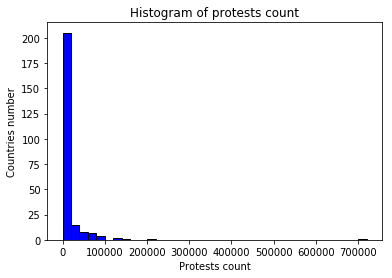

In [22]:
#changing the column name to keep the same naming convention in each dataframe
protests_df=protests_df.rename(index=str, columns={"ISO3": "Country Code"})

#counting the number of protests we have in each country
number_of_protests_per_country = protests_df.groupby(['Country Code']).size().reset_index(name='protests count')

#Getting the distribution of protests count
plt.hist(number_of_protests_per_country['protests count'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of protests count')
plt.xlabel('Protests count')
plt.ylabel('Countries number')


The distribution show that few countries have a very high number of protests. These countries, with a very high number, hids the nuance between other countries.

For instance, if a country A has 1 protests, a country B has 5000 protests and country C has 100 000 protests, we won't see any difference between country A and B in the visualization. A threshold resolves this issue.

To resolve this issue we thought about two different solutions:
- adding a threshold: but we loose nuance between countries with higher number of protests
- doing a log scale

##### Threshold:

Text(0, 0.5, 'Countries number')

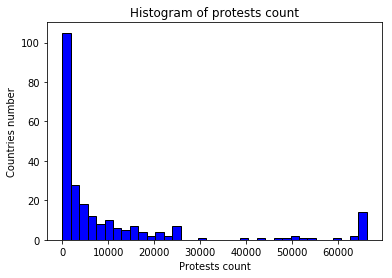

In [23]:
threshold = np.percentile(number_of_protests_per_country['protests count'], 95)
number_of_protests_per_country_thresh = number_of_protests_per_country.copy()
number_of_protests_per_country_thresh[number_of_protests_per_country_thresh['protests count'] > threshold] = threshold

#Getting the new distribution of protests count after the threshold
plt.hist(number_of_protests_per_country_thresh['protests count'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of protests count')
plt.xlabel('Protests count')
plt.ylabel('Countries number')

#### Log scale:

Text(0, 0.5, 'Countries number')

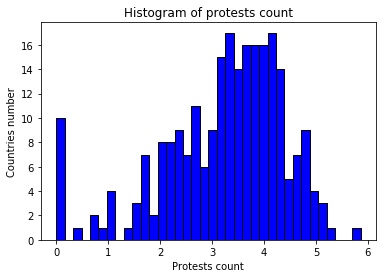

In [24]:
number_of_protests_per_country['log protests count'] = np.log10(number_of_protests_per_country['protests count'])
#Getting the distribution of logarithmic protests count
plt.hist(number_of_protests_per_country['log protests count'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of protests count')
plt.xlabel('Protests count')
plt.ylabel('Countries number')

Visualizing result for log scale that allows to avoid loosing nuance between low values and between high values:

In [25]:

max_nb_protests = number_of_protests_per_country['protests count'].values.max()
colormap = linear.YlGn_09.scale(0, max_nb_protests)
colormap.caption = 'Number of protests since 2005'
swiss_loc=[46.9,8.25]
results_map_protests = folium.Map(swiss_loc, tiles='cartodbpositron', zoom_start=1) 
#creating dictionary to easily find the protest count
dictionary = number_of_protests_per_country.set_index('Country Code')['protests count']

folium.TopoJson(
    countries_topodata,
#     open('data/contries.topojson.json'),
    'objects.countries1',
    style_function=lambda x: {
        'fillColor': '#black' if (x['id'] not in dictionary.index.values) or (pd.isnull(dictionary[x['id']])) else (colormap(dictionary[x['id']])),
        'color': 'black',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },
    tooltip=folium.GeoJsonTooltip(fields=['name'],
                                  aliases=[''], 
                                  sticky=True, 
                                  style="font-family: Arial; color: black;", 
                                  opacity=0.8, 
                                  direction='top')
).add_to(results_map_protests)
results_map_protests.add_child(colormap) #adding legend to map


results_map_protests.save('results_map_protests.html')
display(HTML("<h1><a href='results_map_protests.html' target='_blank'>results_map_protests (Ctrl+Click)</a></h1>"))

results_map_protests

### Same map in log scale

In [26]:
max_nb_protests = number_of_protests_per_country['log protests count'].values.max()
colormap = linear.YlGn_09.scale(0, max_nb_protests)
colormap.caption = 'Number of protests since 2005 (log scale)'
swiss_loc=[46.9,8.25]
results_map_protests = folium.Map(swiss_loc, tiles='cartodbpositron', zoom_start=1) 
#creating dictionary to easily find the protest count
dictionary = number_of_protests_per_country.set_index('Country Code')['log protests count']

folium.TopoJson(
    countries_topodata,
#     open('data/contries.topojson.json'),
    'objects.countries1',
    style_function=lambda x: {
        'fillColor': '#black' if (x['id'] not in dictionary.index.values) or (pd.isnull(dictionary[x['id']])) else (colormap(dictionary[x['id']])),
        'color': 'black',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },
    tooltip=folium.GeoJsonTooltip(fields=['name'],
                                  aliases=[''], 
                                  sticky=True, 
                                  style="font-family: Arial; color: black;", 
                                  opacity=0.8, 
                                  direction='top')
).add_to(results_map_protests)
results_map_protests.add_child(colormap) #adding legend to map


results_map_protests.save('results_map_protests_log_scale.html')
display(HTML("<h1><a href='results_map_protests_log_scale.html' target='_blank'>results_map_protests (Ctrl+Click)</a></h1>"))

results_map_protests

Remark: you can focus your mouse on each country to get his name.

### Is there any correlation between number of protests and other statistics?

In [27]:
#Getting number of protests per country without any threshold
number_of_protests_per_country = protests_df.groupby(['Country Code']).size().reset_index(name='protests count')

In [28]:
#Extracting the two column we are interesting in
country_by_income_2017_filtered=country_by_income_2017[['Country Code','Income Group']]

In [29]:
#joining tables to get the country, the income group and the protests count in the same table
income_group_and_protests_count=pd.merge(country_by_income_2017_filtered, number_of_protests_per_country, how='right', on=['Country Code'])
income_group_and_protests_count.head()

,Country Code,Income Group,protests count
0,ZWE,1.0,15899
1,ZMB,3.0,2913
2,YEM,1.0,24011
3,PSE,3.0,19958
4,VIR,6.0,147


In [30]:
countries_stats_with_code=pd.merge(countries_stats, country_codes_to_name, how='left', on='Country Name')
countries_stats_with_code=countries_stats_with_code.dropna()

In [31]:
#Getting a dataframe with all the statistics by country!
countries_all_stats=pd.merge(countries_stats_with_code, income_group_and_protests_count, how='left', on='Country Code')
countries_all_stats=countries_all_stats.dropna()
#Using countries that have more than 1 protest for the linear regression
countries_all_stats=countries_all_stats[countries_all_stats['protests count'] > 1]
countries_all_stats.head()

,Country Name,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,Country Code,Income Group,protests count
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,...,87.65,1.0,46.60,20.34,0.380,0.240,0.380,AFG,1.0,20772.0
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,...,74.49,3.0,15.11,5.22,0.232,0.188,0.579,ALB,4.0,17942.0
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,...,96.53,1.0,17.14,4.61,0.101,0.600,0.298,DZA,4.0,8377.0
4,Argentina,LATIN AMER. & CARIB,39921833,2766890,14.4,0.18,0.61,15.18,11200.0,97.1,...,87.21,3.0,16.73,7.55,0.095,0.358,0.547,ARG,6.0,23984.0
5,Armenia,C.W. OF IND. STATES,2976372,29800,99.9,0.00,-6.47,23.28,3500.0,98.6,...,80.15,4.0,12.07,8.23,0.239,0.343,0.418,ARM,4.0,16292.0


In the dataframe above, we can access many statistics on each country such as density population, GDP (Gross Domestic Product), birthrate, deathrate, infant mortality, etc. Thanks to all this available data, we can perform a linear regression to get an idea of the impact of each variable on the number of protests (stored in the dataframe too):

In [32]:
#Using linear regression to find impact of each variable on the protests count
feature_cols = ['Population', 'Area (sq. mi.)','Net migration', 'Infant mortality (per 1000 births)',
                'GDP ($ per capita)', 'Deathrate', 'Phones (per 1000)', 'Birthrate',
                'Coastline (coast/area ratio)', 'Literacy (%)', 'Arable (%)', 'Crops (%)']
X = countries_all_stats[feature_cols]
X['nb_telephon'] = X['Population'] * X['Phones (per 1000)'] / 1000

y = countries_all_stats['protests count']
logistic = LinearRegression()  # create the model
logistic.fit(X, y)  # train it
for f in range(len(feature_cols)):
    print("{0} * {1} + ".format(logistic.coef_[f], feature_cols[f]))
print(logistic.intercept_)

-0.00012198554244001186 * Population + 
0.012891948126387078 * Area (sq. mi.) + 
-408.37009319587764 * Net migration + 
103.179023143913 * Infant mortality (per 1000 births) + 
0.6339071323003178 * GDP ($ per capita) + 
-966.6910099652445 * Deathrate + 
49.951954986084026 * Phones (per 1000) + 
652.9298573476309 * Birthrate + 
-85.56621753599944 * Coastline (coast/area ratio) + 
-189.7390856946759 * Literacy (%) + 
1042.136797094264 * Arable (%) + 
-181.86321310953414 * Crops (%) + 
-13955.450598542498


C:\Users\bronner\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
# np.log(y)

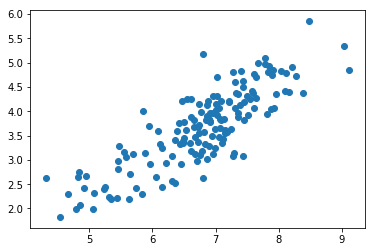

In [34]:

plt.scatter(np.log10(X['Population']),np.log10(y))
# plt.yscale('log')
# plt.xscale('log')

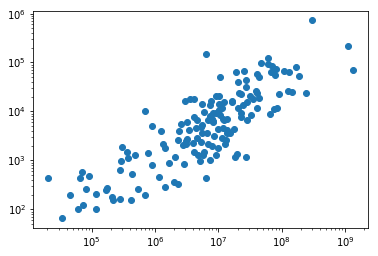

In [35]:
plt.scatter(X['Population'],y)
plt.yscale('log')
plt.xscale('log')

## Comment:
The variable were not normalized the coefficient doesn't represent the importance of each feature. For example the percentage can obviously vary from 0 to 100 when the population varies from 20 thousand to 1.3 billion.

So we next check if these coefficents are statistically significant. To do so we will look at the P value for each variable. We use the standard threshold of 0.05, below this threshold the Null hypothesis is rejected.

In [36]:
# scipy.stats.ttest_ind(two_data.loc['cat'], two_data.loc['cat2'], equal_var=False)
# X2

In [37]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         protests count   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     12.43
Date:                Sat, 08 Dec 2018   Prob (F-statistic):           9.18e-18
Time:                        22:06:33   Log-Likelihood:                -1875.7
No. Observations:                 155   AIC:                             3779.
Df Residuals:                     141   BIC:                             3822.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## Comments

Three variables have a P-value smaller than 0.05. The Area, the percentage of Arable land and the number of phones per 1000 people. 

However, we should be careful when analysing those results. Correlation doesn't mean causality. 

We could argue that as only the number of protests is recorded not their importance. The size of the country could have a role, in a small country the people will gather in only a few cities, when in a large country people will do smaller but more numerous protest spread across the country. 

The number of phones could also play a role as it it made small protests more visible.

However, it is difficult to see how the percentage of arable land plays a role.

Finally, we have shown above that the USA is a clear outlier. Thus the regression can simply show that the number of protests is related to have similar statistic as the USA.

## Add variables
### (HDI: Human Development Index)

In [38]:
HDI = pd.read_csv(DATA_PATH + 'Human_Development_Index_(HDI).csv', encoding='latin1')
HDI_2017 = HDI[['Country', '2017']]
HDI_2017.columns = ['Country Name', 'HDI']
#clean it 
HDI_2017['Country Name'] = HDI_2017['Country Name'].apply(lambda x: x.strip())
countries_all_stats2 = pd.merge(countries_all_stats, HDI_2017, on='Country Name', how = 'inner')

C:\Users\bronner\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Check the new regression

In [39]:
#Using linear regression to find impact of each variable on the protests count
feature_cols = ['Population', 'Area (sq. mi.)','Net migration', 'Infant mortality (per 1000 births)',
                'GDP ($ per capita)', 'Deathrate', 'Phones (per 1000)', 'Birthrate',
                'Coastline (coast/area ratio)', 'Literacy (%)', 'Arable (%)', 'Crops (%)', 'HDI']
X = countries_all_stats2[feature_cols]
y = countries_all_stats2['protests count']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         protests count   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     8.552
Date:                Sat, 08 Dec 2018   Prob (F-statistic):           3.47e-12
Time:                        22:06:33   Log-Likelihood:                -1685.3
No. Observations:                 138   AIC:                             3399.
Df Residuals:                     124   BIC:                             3440.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## comment:
The HDI doesn't seem to matter for the number of protests in a country, at least we cannot reject the null hypothesis that says it has no influence.

# Getting the other tables:

- press_freedom_df : press freedom for each country from 2002  to 2018
- corruption_df : corruption id  for each country from 2005 to 2017
- gdp_df : gdp  for each country from 2005 to 2017
- gini_df: gini for each country from 2005 to 2017
- hdi_df :Human Development Index  for each country from 2005 to 2017 


We import the Human Development Index, the description and the source is at the beguining of the notebook

In [40]:
hdi_df = pd.read_csv(DATA_PATH + "Human_Development_Index_(HDI).csv", encoding = "ISO-8859-1")
hdi_df.head(5)

,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.437,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498
1,68,Albania,0.645,0.626,0.610,0.613,0.619,0.632,0.641,0.641,...,0.724,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785
2,85,Algeria,0.577,0.581,0.587,0.591,0.595,0.600,0.608,0.617,...,0.709,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.753,0.754
3,35,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.831,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858
4,147,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.502,0.522,0.520,0.535,0.543,0.554,0.564,0.572,0.577,0.581


The data-set seems already cleaned. As we want the data only from 2005 to 2017 we remove the column from 1990 to 2004.

In [41]:
hdi_df = hdi_df.drop(hdi_df.iloc[:,2:17], axis = 1)
hdi_df.head(5)

,HDI Rank (2017),Country,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,0.408,0.417,0.429,0.437,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498
1,68,Albania,0.704,0.711,0.720,0.724,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785
2,85,Algeria,0.692,0.698,0.707,0.709,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.753,0.754
3,35,Andorra,0.819,0.829,0.829,0.831,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858
4,147,Angola,0.455,0.471,0.492,0.502,0.522,0.520,0.535,0.543,0.554,0.564,0.572,0.577,0.581


We import the gini Index, the description and the source is at the beguining of the notebook

In [42]:
gini_df = pd.read_csv(DATA_PATH + "GINI_per_country_worldbank.csv", encoding = "ISO-8859-1")
gini_df.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are lot of NaN in this data-set we remove unrelevant columns 

In [43]:
gini_df = gini_df.drop(gini_df.iloc[:,2:49], axis = 1)
gini_df.head(5)

,Country Name,Country Code,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will replace these NaN with 0
We now import GDP data

In [44]:

gdp_df = pd.read_csv(DATA_PATH + "GDP_growth_world_bank.csv", encoding = "ISO-8859-1")
gdp_df.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.881302,-5.653502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,3.611368,21.020649,8.433290,6.113685,14.434741,3.900575,2.690522,1.310040,2.366712,2.595542
2,Angola,AGO,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,13.817098,2.412910,3.452875,3.873331,5.177594,6.842717,4.703971,2.999747,-0.813494,0.721699
3,Albania,ALB,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,3.760854,3.352610,3.710058,2.550161,1.419968,1.000755,1.774369,2.218752,3.352159,3.841364
4,Andorra,AND,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.590004,-3.690654,-5.358826,-4.646543,-1.615218,0.351645,2.277683,0.842204,1.889124,1.873197


We remove useless column to only keep^country and years from 2005 to 2017

In [45]:
gdp_df = gdp_df.drop(gdp_df.iloc[:,2:49], axis = 1)
gdp_df.head(5)

,Country Name,Country Code,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,0.380391,2.355119,-3.654626,-6.881302,-5.653502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,11.175270,5.554138,13.740205,3.611368,21.020649,8.433290,6.113685,14.434741,3.900575,2.690522,1.310040,2.366712,2.595542
2,Angola,AGO,20.907027,18.989035,23.189597,13.817098,2.412910,3.452875,3.873331,5.177594,6.842717,4.703971,2.999747,-0.813494,0.721699
3,Albania,ALB,5.720820,5.431013,5.900000,3.760854,3.352610,3.710058,2.550161,1.419968,1.000755,1.774369,2.218752,3.352159,3.841364
4,Andorra,AND,7.396983,4.536353,0.040011,-8.590004,-3.690654,-5.358826,-4.646543,-1.615218,0.351645,2.277683,0.842204,1.889124,1.873197


We import data about corruption

In [46]:
corruption_df = pd.read_csv(DATA_PATH + "DataCorruptionPerceptionIndex2000_2017.csv", encoding = "ISO-8859-1")
corruption_df.head(5)

,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,New Zealand,94,94,95,95,96,96,96,94,93,94,93,95,90.0,91.0,91.0,91.0,90.0,89
1,Denmark,98,95,95,95,95,95,95,94,93,93,93,94,90.0,91.0,92.0,91.0,90.0,88
2,Finland,100,99,97,97,97,96,96,94,90,89,92,94,90.0,89.0,89.0,90.0,89.0,85
3,Norway,91,86,85,88,89,89,88,87,79,86,86,90,85.0,86.0,86.0,88.0,85.0,85
4,Switzerland,86,84,85,88,91,91,91,90,90,90,87,88,86.0,85.0,86.0,86.0,86.0,85


In [47]:
corruption_df = corruption_df.drop(corruption_df.iloc[:,1:6], axis = 1)
corruption_df.head(5)

,Country,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,New Zealand,96,96,94,93,94,93,95,90.0,91.0,91.0,91.0,90.0,89
1,Denmark,95,95,94,93,93,93,94,90.0,91.0,92.0,91.0,90.0,88
2,Finland,96,96,94,90,89,92,94,90.0,89.0,89.0,90.0,89.0,85
3,Norway,89,88,87,79,86,86,90,85.0,86.0,86.0,88.0,85.0,85
4,Switzerland,91,91,90,90,90,87,88,86.0,85.0,86.0,86.0,86.0,85


For press_freedom_df, we took the data from wikipedia,
https://en.wikipedia.org/wiki/Press_Freedom_Index
we copied the table to a text file: 'parse.txt' 
We created a small script to parse and convert these data to dataframe.

In [48]:
filepath = DATA_PATH+'parse.txt'  
with open(filepath) as fp:  
    line = fp.readline()
    cnt = 0
    while cnt <= 20: 
        cnt+=1
        print(line)
        line = fp.readline()
fp.close()



 Norway	(001)

7.63	(001)

7.6	(003)

8.79	(002)

7.75	(003)

6.52	(003)

6.52	(001)

-10.00	(001)

0.00	(001)

0.00	(001)

1.50	(001)

0.75	(006)

2.00	(001)

0.50	(001)

0.50	(001)

0.50	(001)

0.50

 Sweden	(002)

8.31	(002)

8.27	(008)



This looks really messy, but in fact, the values under each country name are the indices from 2018 t 2002 and the number in parenthsis is the rank for each year.
We create a dataframe with press-freedom indices corresponding to each country and  each year.

In the algorithm bellow we parse these data to generate the dataframe

According to wikipeddia, 2011 is missing because the report released in 2012 is titled '2011–2012' and cover both 2011 and 2012 in one column. 
We will later see what we can do to recover these missing data.

In [49]:

#initilize empty dataframe with corresponding columns
columns_data=['Country','2018', '2017', '2016', '2015', '2014','2013', '2012','2011', '2010', '2009','2008', '2007', '2006', '2005', '2004','2003', '2002']
press_freedom_df =  pd.DataFrame(columns = columns_data, index = range(0,200))

In [50]:
filepath = DATA_PATH+'parse.txt'   
#press_freedom_df
index = []
values = []


with open(filepath) as fp:  
    line = fp.readline()
    column = 0
    cnt = 0
    line = fp.readline()


    while cnt <= 179: #179 counrty in the file
       
        
        if(line[0] == ' '): #if we detect the space in front of country name
            cnt+=1 # row = row + 1
            column = 0
            values.append(line.split('\t')[0]) #Only keep the name of the counrty and not the shifted rank
            line = fp.readline()
        else:
            while(line[0] != ' '): #While these are the index correspnding to the country detected above
                
                column += 1
                values.append(line.split()[0]) #Only keeps the index and not the ranking
                
                line = fp.readline()
           
            row = pd.Series( (v for v in values) )
            values = []
            
            n = 0
            for i in range(len(row)):
                if(i == 0):
                    press_freedom_df['Country'].iloc[cnt] = row.iloc[0] #name in country column
                else:
                    if(2019 - i == 2011):
                        n = 1
                    press_freedom_df[str(2019-i-n)].iloc[cnt] = row.iloc[i] # index corresponding to year
                    
            
fp.close()            
            
            
            
   

In [51]:
press_freedom_df.head(5) # let''s remove these NAN row that are at the beguining and at the end

,Country,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Norway,7.63,7.6,8.79,7.75,6.52,6.52,-10.00,NaN,0.00,0.00,1.50,0.75,2.00,0.50,0.50,0.50,0.50
2,Sweden,8.31,8.27,12.33,9.47,8.98,9.23,-5.50,NaN,0.00,0.00,3.00,1.50,4.00,2.00,2.00,1.50,1.50
3,Netherlands,10.01,11.28,8.76,9.22,6.46,6.48,-9.00,NaN,0.00,1.00,4.00,3.50,0.50,0.50,0.50,0.50,0.50
4,Finland,10.26,8.92,8.59,7.52,6.40,6.38,-10.00,NaN,0.00,0.00,2.00,1.50,0.50,0.50,0.50,0.50,0.50


In [52]:
press_freedom_df = press_freedom_df.drop(0)
press_freedom_df = press_freedom_df.head(179)
press_freedom_df.head(5)

,Country,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
1,Norway,7.63,7.6,8.79,7.75,6.52,6.52,-10.00,NaN,0.00,0.00,1.50,0.75,2.00,0.50,0.50,0.50,0.50
2,Sweden,8.31,8.27,12.33,9.47,8.98,9.23,-5.50,NaN,0.00,0.00,3.00,1.50,4.00,2.00,2.00,1.50,1.50
3,Netherlands,10.01,11.28,8.76,9.22,6.46,6.48,-9.00,NaN,0.00,1.00,4.00,3.50,0.50,0.50,0.50,0.50,0.50
4,Finland,10.26,8.92,8.59,7.52,6.40,6.38,-10.00,NaN,0.00,0.00,2.00,1.50,0.50,0.50,0.50,0.50,0.50
5,Switzerland,11.27,12.13,11.76,13.85,10.47,9.94,-6.20,NaN,0.00,1.00,3.00,3.00,2.50,0.50,0.50,2.50,4.25


As explained above, it is normal if the 2011 column is full of NaN. We will correct this after( probably with a linear interpolation).

##### During all these years , the indicators that were used to calculate all these indexes evolved. The metrics is different between 2005 and 2017. For example in 2013, Reporters Without  Borders changed their  index for press-freedom.As it is relative to other country, it is not changing the interpretation (lowest index = most free) 

##### That mean that all these data have to be standardize before comparing between years.

# A list of internal milestones until the presentation.

<u>**28/11/2018:**</u> Do the same analysis for different kind of protests such as the violent ones.
<br><br>
<u>**29/11/2018:**</u> deadline for finding new statistics on the countries (already more than 10 but it could be interesting to find other variables to evaluate.
<br><br>
<u>**31/11/2018:**</u> doing the analysis on each country but depending on the year. Finding a way to visualize the evolution of the protests numbers year per year
<br><br>
<u>**02/12/2018:**</u> finding impact of each variables on the protests number on each country based on the year As we have the number of protests per year and statistics on each country per year, we should be able to see the influence of each variable. For instance, is a country increase a lot his GDP ($ per capita) and not the other variables, and the number of protests decrease we could assume that they are related, etc (that's just a simple example).
<br><br>
<u>**05/12/2018:**</u> we though about implementing a dynamic world map that show the protests days by days in a quick way (to help you understanding what we mean, here an example of the result we would like: https://www.globalforestwatch.org/map
<br><br>
<u>**08/12/2018:**</u> we got almost all the results we wanted, we wrote good comments and explanations. The documentation is well done. We choose the way to present our work: a 4-page PDF document or a data story in a platform like a blog post.
<br><br>
<u>**14/12/2018:**</u> We got all the result we wanted. Our visualizations are good. The report or the data story through a platform is done.
<br><br>
<u>**15/12/2018:**</u> Last verifications for the deadline of the Dec. 16, 2018.
<br><br>
<u>**21/12/2018:**</u> Design of the poster, the presentation is ready
<br><br>**Presentation J-2:** Printing the poster.


In [86]:
violent_protests_df.dropna
violent_protests_df2=pd.merge(violent_protests_df, country_codes_fips104_to_iso3, how='right', left_on=['CountryCode'], right_on=['FIPS 10-4'])
violent_protests_df2.head()

,ID,CountryCode,EventCode,Year,NumMentions,NumSources,NumArticles,AvgTone,FIPS 10-4,ISO3
0,631000527.0,AA,145.0,2017.0,2.0,1.0,2.0,-1.192843,AA,ABW
1,631000719.0,AA,145.0,2017.0,2.0,1.0,2.0,-1.192843,AA,ABW
2,426935819.0,AA,145.0,2015.0,3.0,1.0,3.0,-8.880309,AA,ABW
3,457574653.0,AA,145.0,2015.0,4.0,1.0,4.0,0.416667,AA,ABW
4,706286293.0,AA,145.0,2017.0,5.0,1.0,5.0,-3.206997,AA,ABW


In [54]:
violent_protests_df.head()#.NumMentions.max()

,ID,CountryCode,EventCode,Year,NumMentions,NumSources,NumArticles,AvgTone
20000,631000527,AA,145,2017,2,1,2,-1.192843
20001,631000719,AA,145,2017,2,1,2,-1.192843
20002,426935819,AA,145,2015,3,1,3,-8.880309
20003,457574653,AA,145,2015,4,1,4,0.416667
20004,706286293,AA,145,2017,5,1,5,-3.206997


In [55]:
# number_of_mention_of_protests_per_country = protests_df.filter(protests_df.NumMentions > 1)
# protests_df.where(protests_df.NumMentions > 10).groupby(['Country Code']).agg(\
#     {'ID': 'count', 'NumMentions': 'mean', 'NumSources': 'mean', 'NumArticles': 'mean', 'AvgTone':'mean'})
protests_df.head()

,ID,CountryCode,EventCode,Year,NumMentions,NumSources,NumArticles,AvgTone,FIPS 10-4,Country Code
0,542110774.0,PE,141.0,2016.0,30.0,1.0,30.0,-3.357314,PE,PER
1,542082949.0,PE,141.0,2016.0,30.0,5.0,30.0,-10.875725,PE,PER
2,542366236.0,PE,141.0,2016.0,15.0,1.0,10.0,-6.493506,PE,PER
3,545932451.0,PE,141.0,2016.0,40.0,4.0,40.0,-0.203252,PE,PER
4,545857774.0,PE,141.0,2016.0,14.0,1.0,10.0,-1.312336,PE,PER


In [78]:
# number_of_mention_of_protests_per_country = protests_df.filter(protests_df.NumMentions > 10).groupby(['CountryCode']).agg(\
#     {'ID': 'count', 'NumMentions': 'mean', 'NumSources': 'mean', 'NumArticles': 'mean', 'AvgTone':'mean'})
number_of_mention_of_protests_per_country = protests_df[protests_df['Year']==2016].groupby(['Country Code']).agg(\
    {'ID': 'count', 'NumMentions': 'mean', 'NumSources': 'mean', 'NumArticles': 'mean', 'AvgTone':'mean'})
number_of_mention_of_violent_protests_per_country = violent_protests_df.groupby(['CountryCode']).agg(\
    {'ID': 'count', 'NumMentions': 'mean', 'NumSources': 'sum', 'NumArticles': 'sum', 'AvgTone':'mean'})
number_of_mention_of_protests_per_country.reset_index(inplace=True)
number_of_mention_of_violent_protests_per_country.reset_index(inplace=True)
number_of_mention_of_violent_protests_per_country.columns=['Country Code', 'Nb protests', 'Mean Nb mention', 'Mean Nb sources', 'Mean Nb Article', 'Mean AvgTone']
number_of_mention_of_protests_per_country.columns=['Country Code', 'Nb protests', 'Mean Nb mention', 'Mean Nb sources', 'Mean Nb Article', 'Mean AvgTone']

protests_df.groupby(['CountryCode']).AvgTone.apply(lambda c: c.abs().mean())

number_of_mention_of_violent_protests_per_country.head()

,Country Code,Nb protests,Mean Nb mention,Mean Nb sources,Mean Nb Article,Mean AvgTone
0,AA,12,7.916667,12,75,-3.861161
1,AC,14,5.000000,15,70,-5.082610
2,AE,506,5.531621,554,2770,-3.910312
3,AF,1690,6.004734,1779,9932,-5.193401
4,AG,681,7.565345,696,4905,-4.061033


In [57]:
number_of_mention_of_protests_per_country_per_year = protests_df.groupby(['Country Code', 'Year']).agg(\
    {'ID': 'count', 'NumMentions': 'mean', 'NumSources': 'mean', 'NumArticles': 'mean', 'AvgTone':'mean'})
number_of_mention_of_protests_per_country_per_year

ID  NumMentions  NumSources  NumArticles   AvgTone
Country Code Year                                                         
ABW          2014.0      2     5.000000    1.000000     5.000000 -1.818182
             2015.0     43     8.069767    1.023256     8.069767 -4.436217
             2016.0     31     9.225806    1.032258     8.580645 -0.545041
             2017.0     28     6.892857    1.107143     6.892857 -1.502655
             2018.0     16     8.687500    1.000000     8.062500 -2.145883
AFG          2005.0      8     4.000000    1.000000     4.000000 -3.507519
             2008.0      2     5.000000    1.000000     5.000000 -6.756757
             2014.0     16     7.625000    1.000000     7.625000 -2.541128
             2015.0   4820     5.801867    1.062033     5.728631 -5.148520
             2016.0   6977     5.749176    1.059768     5.689981 -4.950125
             2017.0   4963     6.197864    1.058231     5.984687 -5.226792
             2018.0   3986     6.285499    1.099599     6.028600 -5.222077
AGO          2014.0     17     6.470588    1.000000     6.470588 -0.326495
             2015.0    962     7.147609    1.040541     7.074844 -4.469575
             2016.0    825     7.760000    1.046061     7.520000 -3.649038
             2017.0    737     6.899593    1.014925     6.810041 -2.305737
             2018.0    595     9.055462    1.011765     7.794958 -2.761963
AIA          2015.0     18     6.166667    1.000000     6.166667  1.673242
             2016.0      7     9.142857    1.000000     9.142857  2.807747
             2017.0     21     6.761905    1.000000     6.761905 -1.783960
             2018.0     11     7.636364    1.000000     7.636364  0.859246
ALB          2014.0      1     8.000000    1.000000     8.000000 -1.145833
             2015.0   1615     7.679257    1.064396     7.552322 -4.313132
             2016.0   4623     8.615834    1.016872     6.814839 -3.904856
             2017.0   6394     9.036440    1.034251     6.758836 -3.840276
             2018.0   5309     8.531739    1.016576     6.810510 -5.164884
AND          2015.0     33    10.121212    1.060606    10.121212 -0.792287
             2016.0     73     9.794521    1.068493     9.383562 -2.204271
             2017.0     57     9.157895    1.035088     9.157895 -0.896891
             2018.0     91     7.571429    1.000000     7.549451 -2.084327
...                    ...          ...         ...          ...       ...
WSM          2015.0     27     6.074074    1.000000     6.074074 -0.621068
             2016.0     60     5.483333    1.016667     5.483333 -0.769297
             2017.0    116     5.913793    1.034483     5.853448 -0.935380
             2018.0     68     4.867647    1.000000     4.867647 -3.078232
YEM          2014.0     25     5.560000    1.000000     5.080000 -4.289634
             2015.0   7226     6.754774    1.061445     6.595627 -4.402165
             2016.0   6586     7.219557    1.039326     6.822350 -4.354418
             2017.0   6534     8.213499    1.070707     7.153046 -4.166222
             2018.0   3640     6.942033    1.045604     6.332418 -3.923008
ZAF          2005.0      6     7.500000    1.000000     7.500000 -4.811778
             2006.0      1     5.000000    1.000000     5.000000 -1.013171
             2007.0      1    10.000000    1.000000    10.000000 -7.196030
             2008.0      2     3.500000    1.000000     3.500000  0.385863
             2014.0     93     5.709677    1.150538     5.709677 -3.118758
             2015.0  11801     5.003474    1.050928     4.891026 -3.870978
             2016.0  15266     5.115223    1.027316     5.009695 -3.786814
             2017.0  13940     4.763056    1.029125     4.662482 -3.804637
             2018.0  10375     4.944964    1.014361     4.773590 -3.913719
ZMB          2014.0      2     2.500000    1.000000     2.500000 -4.878049
             2015.0    639     5.342723    1.009390     5.284820 -1.772544
             2016.0   1082     5.495379    1.0314

In [58]:
violent_protests_df2=pd.merge(violent_protests_df, country_codes_fips104_to_iso3, how='right', left_on=['CountryCode'], right_on=['FIPS 10-4'])
violent_protests_df2
number_of_mention_of_violent_protests_per_country2 = violent_protests_df2.groupby(['CountryCode']).agg(\
    {'ID': 'count', 'NumMentions': 'sum', 'NumSources': 'sum', 'NumArticles': 'sum', 'AvgTone': 'std'})
number_of_mention_of_violent_protests_per_country2
violent_protests_df2.groupby(['CountryCode']).AvgTone.apply(lambda c: c.abs().mean())

CountryCode
AA    3.930606
AC    5.082610
AE    4.314091
AF    5.252229
AG    4.348534
AJ    4.253475
AL    5.747192
AM    4.675935
AN    2.119452
AO    3.570579
AQ    0.812093
AR    4.271432
AS    5.358938
AU    3.892726
AV    5.325649
AY    2.058257
BA    8.216354
BB    3.402515
BC    4.072085
BD    3.449741
BE    4.506102
BF    3.896836
BG    4.650644
BH    3.147580
BK    7.511268
BL    4.230201
BM    5.234435
BN    2.281195
BO    4.197916
BP    3.107007
        ...   
TN    3.309173
TO    5.148651
TS    6.040763
TT    3.147953
TU    4.995820
TV    4.697285
TW    4.471411
TX    3.816764
TZ    4.849747
UG    5.540981
UK    4.201604
UP    4.729207
US    4.617820
UV    3.703183
UY    4.367718
UZ    4.798303
VC    5.291898
VE    5.870040
VI    4.833953
VM    4.304955
VQ    6.167095
VT    3.799269
WA    4.099005
WE    6.666597
WI    2.588444
WS    2.820073
WZ    3.191797
YM    4.286593
ZA    6.172398
ZI    4.524136
Name: AvgTone, Length: 224, dtype: float64

In [59]:
max_nb_protests = number_of_mention_of_protests_per_country['Mean Nb mention'].max()
colormap = linear.BuPu_09.scale(number_of_mention_of_protests_per_country['Mean Nb mention'].min(), max_nb_protests)

colormap.caption = 'Mean Nb mention'
swiss_loc=[46.9,8.25]
results_map_protests = folium.Map(swiss_loc, tiles='cartodbpositron', zoom_start=1) 
#creating dictionary to easily find the protest count
dictionary = number_of_mention_of_protests_per_country.set_index('Country Code')['Mean Nb mention']

folium.TopoJson(
    countries_topodata,
#     open('data/contries.topojson.json'),
    'objects.countries1',
    style_function=lambda x: {
        'fillColor': '#black' if (x['id'] not in dictionary.index.values) or (pd.isnull(dictionary[x['id']])) else (colormap(dictionary[x['id']])),
        'color': 'black',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },
    tooltip=folium.GeoJsonTooltip(fields=['name'],
                                  aliases=[''], 
                                  sticky=True, 
                                  style="font-family: Arial; color: black;", 
                                  opacity=0.8, 
                                  direction='top')
).add_to(results_map_protests)
results_map_protests.add_child(colormap) #adding legend to map


# results_map_protests.save('results_map_protests_log_scale.html')
# display(HTML("<h1><a href='results_map_protests_log_scale.html' target='_blank'>results_map_protests (Ctrl+Click)</a></h1>"))

results_map_protests

In [60]:
col='Nb protests'

max_nb_protests = number_of_mention_of_protests_per_country[col].max()
colormap = linear.BuPu_09.scale(number_of_mention_of_protests_per_country[col].min(), number_of_mention_of_protests_per_country[col].max())
colormap2 = linear.BuPu_09.scale(number_of_mention_of_protests_per_country['Mean Nb mention'].min(), max_nb_protests)
colormap.caption = 'Number of protests since 2005 (log scale)'
swiss_loc=[46.9,8.25]
results_map_protests = folium.Map(swiss_loc, tiles='cartodbpositron', zoom_start=1) 
#creating dictionary to easily find the protest count
dictionary = number_of_mention_of_protests_per_country.set_index('Country Code')[col]

folium.TopoJson(
    countries_topodata,
#     open('data/contries.topojson.json'),
    'objects.countries1',
    style_function=lambda x: {
        'fillColor': '#black' if (x['id'] not in dictionary.index.values) or (pd.isnull(dictionary[x['id']])) else (colormap(dictionary[x['id']])),
        'color': 'black',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },
    tooltip=folium.GeoJsonTooltip(fields=['Alpha-2'],
                                  aliases=[''], 
                                  sticky=True, 
                                  style="font-family: Arial; color: black;", 
                                  opacity=0.8, 
                                  direction='top')
).add_to(results_map_protests)
results_map_protests.add_child(colormap) #adding legend to map


# results_map_protests.save('results_map_protests_log_scale.html')
# display(HTML("<h1><a href='results_map_protests_log_scale.html' target='_blank'>results_map_protests (Ctrl+Click)</a></h1>"))

results_map_protests

In [61]:
country_codes_fips104_to_iso3[country_codes_fips104_to_iso3['FIPS 10-4'] =='CL']

,FIPS 10-4,ISO3


In [62]:
south_america_country_code=['VEN', 'GUY', 'SUR',  'BRA', 'COL', 'ECU', 'PER', 'CHL', 'ARG', 'PRY', 'URY']
south_america_countries_protests = number_of_mention_of_protests_per_country[number_of_mention_of_protests_per_country['Country Code'].isin(south_america_country_code)]

In [63]:
countries_all_stats3=pd.merge(countries_stats_with_code, south_america_countries_protests, how='right', on='Country Code')

In [64]:
south_america_countries_protests.head()

,Country Code,Nb protests,Mean Nb mention,Mean Nb sources,Mean Nb Article,Mean AvgTone
7,ARG,7476,8.532370,1.074639,8.216961,-2.936318
28,BRA,18761,9.031288,1.056287,8.653856,-3.627790
36,CHL,3904,8.601691,1.066598,8.178023,-2.979964
43,COL,5218,8.374473,1.062093,8.115178,-2.557774
58,ECU,1579,8.417353,1.078531,8.088664,-3.109646


In [65]:
# south_america_countries_protests.to_csv('south_ame2.csv')
south_america_countries_protests.head()

,Country Code,Nb protests,Mean Nb mention,Mean Nb sources,Mean Nb Article,Mean AvgTone
7,ARG,7476,8.532370,1.074639,8.216961,-2.936318
28,BRA,18761,9.031288,1.056287,8.653856,-3.627790
36,CHL,3904,8.601691,1.066598,8.178023,-2.979964
43,COL,5218,8.374473,1.062093,8.115178,-2.557774
58,ECU,1579,8.417353,1.078531,8.088664,-3.109646


In [66]:
south_america_countries_protests2 =pd.read_csv('south_ame2.csv')
countries_all_stats3=pd.merge(countries_stats_with_code, south_america_countries_protests2, how='right', on='Country Code')
south_america_countries_protests2

,Country Code,Nb protests,Mean Nb mention,Mean Nb sources,Mean Nb Article,Mean AvgTone,Gdp growth,Gdp growth year after
0,ARG,7476,8.532370,1.074639,8.216961,-2.936318,-1.82,2.86
1,BRA,18761,9.031288,1.056287,8.653856,-3.627790,-3.47,0.98
2,CHL,3904,8.601691,1.066598,8.178023,-2.979964,1.27,1.49
3,COL,5218,8.374473,1.062093,8.115178,-2.557774,2.04,1.77
4,ECU,1579,8.417353,1.078531,8.088664,-3.109646,-1.58,3.00
5,GUY,364,5.931319,1.021978,5.898352,-3.141521,3.32,2.93
6,PER,4239,7.887002,1.087992,7.493513,-3.273842,3.95,2.53
7,PRY,933,9.045016,1.118971,8.571275,-3.269413,4.02,0.77
8,SUR,119,9.554622,1.000000,9.302521,-2.926788,-5.14,0.10
9,URY,1334,8.272114,1.171664,8.007496,-4.207204,1.69,2.66


In [67]:
#Using linear regression to find impact of each variable on the protests count
feature_cols = ['Population',
                'GDP ($ per capita)','Gdp growth']
feature_cols2 = ['Population',
                'GDP ($ per capita)','Gdp growth']
X = countries_all_stats3[feature_cols2]
# ['Country Code', 'Nb protests', 'Mean Nb mention', 'Mean Nb sources', 'Mean Nb Article', 'Mean AvgTone']

y = countries_all_stats3['Nb protests']/countries_all_stats3['Population']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     2.285
Date:                Sat, 08 Dec 2018   Prob (F-statistic):              0.166
Time:                        22:06:35   Log-Likelihood:                 85.023
No. Observations:                  11   AIC:                            -162.0
Df Residuals:                       7   BIC:                            -160.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0002   9.91

C:\Users\bronner\Miniconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [68]:
number_of_mention_of_protests_per_country_per_year.reset_index(inplace=True)
south_america_countries_protests_per_year = number_of_mention_of_protests_per_country_per_year[number_of_mention_of_protests_per_country_per_year['Country Code'].isin(south_america_country_code)]
south_america_countries_protests_per_year.head()

,Country Code,Year,ID,NumMentions,NumSources,NumArticles,AvgTone
35,ARG,2014.0,45,4.244444,1.000000,4.244444,-3.562716
36,ARG,2015.0,3634,7.723170,1.027243,7.618327,-2.903317
37,ARG,2016.0,7476,8.532370,1.074639,8.216961,-2.936318
38,ARG,2017.0,7266,8.934352,1.057391,8.602257,-3.229253
39,ARG,2018.0,5563,8.626281,1.048535,8.292288,-2.863909


In [69]:
# gdp_growth = pd.read_csv(DATA_PATH + "gdp_growth.csv", error_bad_lines=False, skiprows=3)

# gdp_growth.drop(labels=['Unnamed: 62', 'Indicator Code', 'Indicator Name'], axis=1, inplace=True)
# # gdp_growth.set_index('Country Name', inplace=True)
# gdp_growth.head()

In [221]:
# gdp_growth.columns[2:]
# # pd.pivot_table?
# # pd.pivot(gdp_growth, columns=gdp_growth['Country Name'], values=gdp_growth['Country Code'])
# # gdp_growth.stack()
# # aa=pd.DataFrame(gdp_growth.transpose())

# # print(aa.head(3))
# # aa.set_index(aa.iloc[0].values)
# # pd.pivot_table(aa, columns=)
# gdp_growth.head()
# aa=gdp_growth.pivot(index='Country Name', columns='Country Code')
gdp_growth

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.881302,-5.653502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,3.611368,21.020649,8.433290,6.113685,14.434741,3.900575,2.690522,1.310040,2.366712,2.595542
2,Angola,AGO,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,13.817098,2.412910,3.452875,3.873331,5.177594,6.842717,4.703971,2.999747,-0.813494,0.721699
3,Albania,ALB,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,3.760854,3.352610,3.710058,2.550161,1.419968,1.000755,1.774369,2.218752,3.352159,3.841364
4,Andorra,AND,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.590004,-3.690654,-5.358826,-4.646543,-1.615218,0.351645,2.277683,0.842204,1.889124,1.873197
5,Arab World,ARB,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,5.780130,0.464939,4.748925,3.609238,6.695226,3.134329,2.453629,3.277542,3.004695,1.192246
6,United Arab Emirates,ARE,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,3.191836,-5.242922,1.602810,6.930272,4.484626,5.053346,4.398697,5.064702,2.988442,0.790400
7,Argentina,ARG,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,5.427843,-0.852022,-5.308197,10.130298,10.569433,...,4.057233,-5.918525,10.125398,6.003952,-1.026420,2.405324,-2.512615,2.731160,-1.822542,2.863923
8,Armenia,ARM,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,6.900000,-14.149989,2.200000,4.700000,7.200000,3.300000,3.600000,3.200000,0.200000,7.500000
9,American Samoa,ASM,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.613480,-4.237288,0.442478,0.293686,-4.392387,-2.756508,0.944882,1.248050,-2.619414,NaN


In [222]:
gdp_growth = pd.read_csv(DATA_PATH + "gdp_growth.csv", error_bad_lines=False, skiprows=4)

gdp_growth.drop(labels=[ 'Indicator Code', 'Indicator Name'], axis=1, inplace=True)
aa=gdp_growth.pivot(index='Country Name', columns='Country Code')
aa.head()
aa.fillna(0, inplace=True)
bb=aa.sum(axis=0)
bb.head()#loc['1961'].values.sum()

cc=pd.DataFrame(bb)

cc.index.names = ['Year', 'Country Code']
cc.columns = ['Gdp growth']
# cc.reset_index(inplace=True)
cc.head()

Gdp growth
Year Country Code            
1960 ABW                  0.0
     AFG                  0.0
     AGO                  0.0
     ALB                  0.0
     AND                  0.0

In [223]:
south_america_country_code

['VEN', 'GUY', 'SUR', 'BRA', 'COL', 'ECU', 'PER', 'CHL', 'ARG', 'PRY', 'URY']

In [231]:
protests_stats=protests_df.groupby(['Country Code', 'Year']).agg(\
    {'ID': 'count', 'NumMentions': 'mean', 'NumSources': 'mean', 'NumArticles': 'mean', 'AvgTone':'mean'})

protests_stats.columns=['Nb protests', 'Mean Nb mention', 'Mean Nb sources', 'Mean Nb Article', 'Mean AvgTone']
protests_stats.reset_index(inplace=True)
south_america_country_code=['VEN', 'GUY',  'BRA', 'COL', 'ECU', 'PER', 'CHL', 'ARG', 'PRY', 'URY']
SA_protests_stats = protests_stats[protests_stats['Country Code'].isin(south_america_country_code)]

SA_protests_stats.Year = SA_protests_stats.Year.map(int).map(str)
SA_protests_stats.head()

C:\Users\bronner\Miniconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Country Code,Year,Nb protests,Mean Nb mention,Mean Nb sources,Mean Nb Article,Mean AvgTone
35,ARG,2014,45,4.244444,1.000000,4.244444,-3.562716
36,ARG,2015,3634,7.723170,1.027243,7.618327,-2.903317
37,ARG,2016,7476,8.532370,1.074639,8.216961,-2.936318
38,ARG,2017,7266,8.934352,1.057391,8.602257,-3.229253
39,ARG,2018,5563,8.626281,1.048535,8.292288,-2.863909


In [232]:
# SA_protests_stats.iloc[1].Year
# cc.iloc[1].Year

In [233]:
SA_protests_stats.set_index(['Country Code', 'Year'],inplace=True)
all_SA_stats = pd.merge(SA_protests_stats, cc, on=['Country Code', 'Year'])
# all_SA_stats.reset_index(inplace=True)
all_SA_stats

Nb protests  Mean Nb mention  Mean Nb sources  \
Country Code Year                                                  
ARG          2014           45         4.244444         1.000000   
             2015         3634         7.723170         1.027243   
             2016         7476         8.532370         1.074639   
             2017         7266         8.934352         1.057391   
BRA          2006            3         4.333333         1.000000   
             2014           31         8.322581         1.000000   
             2015        11162         8.794481         1.037448   
             2016        18761         9.031288         1.056287   
             2017        13179         9.287655         1.053115   
CHL          2014            9         8.555556         1.000000   
             2015         3535         7.911174         1.042716   
             2016         3904         8.601691         1.066598   
             2017         4223         8.567132         1.043571   
COL          2006            2         7.500000         1.000000   
             2008            1        10.000000         1.000000   
             2014           24         7.208333         1.041667   
             2015         3351         7.562220         1.029543   
             2016         5218         8.374473         1.062093   
             2017         5803         8.411339         1.048079   
ECU          2014            7         4.285714         1.000000   
             2015         2752         8.307776         1.059593   
             2016         1579         8.417353         1.078531   
             2017         1353         9.071693         1.039911   
GUY          2014            3         3.000000         1.000000   
             2015          342         5.926901         1.026316   
             2016          364         5.931319         1.021978   
             2017          498         6.381526         1.014056   
PER          2014           10         5.400000         1.000000   
             2015         3446         7.658445         1.049913   
             2016         4239         7.887002         1.087992   
             2017         4775         8.498429         1.045864   
PRY          2014            7         4.857143         1.000000   
             2015          784         8.253827         1.084184   
             2016          933         9.045016         1.118971   
             2017         1237        10.109135         1.094584   
URY          2014           22         5.272727         1.227273   
             2015          786         7.968193         1.146310   
             2016         1334         8.272114         1.171664   
             2017         1165         9.888412         1.054936   
VEN          2014          227         7.458150         1.026432   
             2015        10647         8.576313         1.054475   
             2016        14307         8.680087         1.062347   
             2017        31206         9.161828         1.083862   

                   Mean Nb Article  Mean AvgTone  Gdp growth  
Country Code Year                                             
ARG          2014         4.244444     -3.562716   -2.512615  
             2015         7.618327     -2.903317    2.731160  
             2016         8.216961     -2.936318   -1.822542  
             2017         8.602257     -3.229253    2.863923  
BRA          2006         4.333333     -6.416308    3.957297  
             2014         8.064516     -2.183838    0.508210  
             2015         8.636445     -3.056357   -3.549767  
             2016         8.653856     -3.627790   -3.468163  
             2017         8.788907     -3.687688    0.976086  
CHL          2014         8.555556     -3.690282    1.766740  
             2015         7.811315     -3.031572    2.305257  
             2016         8.178023     -2.979964    1.265868  
             2017         8.118636     -3.240414    1.489906  
COL          

### Comments:
There is a dramatic increase in the number of protests between 2014 and 2015, in average 105 times more. This indicate that is is not the same distribution, probably due on how the data is colected.

We are missing the GDP growth for venezuela in 2015, 2016, 2017. We will instead use specialy the data from Wikipedia, which is actually using the same source as ours , thus the data should be taken with a pinch of salt.


In [234]:
all_SA_stats.reset_index(inplace=True)

In [235]:
resent_all_SA_stats=all_SA_stats[all_SA_stats['Year']>'2014']#.filter(all_SA_stats.Year > '2014')

In [236]:
all_SA_stats.loc['VEN'].loc['2015']['Gdp growth'] = -5.72
all_SA_stats.loc['VEN'].loc['2016']['Gdp growth'] = -18
all_SA_stats.loc['VEN'].loc['2017']['Gdp growth'] = -14

KeyError: 'the label [VEN] is not in the [index]'

In [237]:
SA_stats3=pd.merge(countries_stats_with_code, resent_all_SA_stats, how='right', on='Country Code')
SA_stats3

,Country Name,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Industry,Service,Country Code,Year,Nb protests,Mean Nb mention,Mean Nb sources,Mean Nb Article,Mean AvgTone,Gdp growth
0,Argentina,LATIN AMER. & CARIB,39921833,2766890,14.4,0.18,0.61,15.18,11200.0,97.1,...,0.358,0.547,ARG,2015,3634,7.723170,1.027243,7.618327,-2.903317,2.731160
1,Argentina,LATIN AMER. & CARIB,39921833,2766890,14.4,0.18,0.61,15.18,11200.0,97.1,...,0.358,0.547,ARG,2016,7476,8.532370,1.074639,8.216961,-2.936318,-1.822542
2,Argentina,LATIN AMER. & CARIB,39921833,2766890,14.4,0.18,0.61,15.18,11200.0,97.1,...,0.358,0.547,ARG,2017,7266,8.934352,1.057391,8.602257,-3.229253,2.863923
3,Brazil,LATIN AMER. & CARIB,188078227,8511965,22.1,0.09,-0.03,29.61,7600.0,86.4,...,0.400,0.516,BRA,2015,11162,8.794481,1.037448,8.636445,-3.056357,-3.549767
4,Brazil,LATIN AMER. & CARIB,188078227,8511965,22.1,0.09,-0.03,29.61,7600.0,86.4,...,0.400,0.516,BRA,2016,18761,9.031288,1.056287,8.653856,-3.627790,-3.468163
5,Brazil,LATIN AMER. & CARIB,188078227,8511965,22.1,0.09,-0.03,29.61,7600.0,86.4,...,0.400,0.516,BRA,2017,13179,9.287655,1.053115,8.788907,-3.687688,0.976086
6,Chile,LATIN AMER. & CARIB,16134219,756950,21.3,0.85,0.00,8.80,9900.0,96.2,...,0.493,0.447,CHL,2015,3535,7.911174,1.042716,7.811315,-3.031572,2.305257
7,Chile,LATIN AMER. & CARIB,16134219,756950,21.3,0.85,0.00,8.80,9900.0,96.2,...,0.493,0.447,CHL,2016,3904,8.601691,1.066598,8.178023,-2.979964,1.265868
8,Chile,LATIN AMER. & CARIB,16134219,756950,21.3,0.85,0.00,8.80,9900.0,96.2,...,0.493,0.447,CHL,2017,4223,8.567132,1.043571,8.118636,-3.240414,1.489906
9,Colombia,LATIN AMER. & CARIB,43593035,1138910,38.3,0.28,-0.31,20.97,6300.0,92.5,...,0.342,0.533,COL,2015,3351,7.562220,1.029543,7.462847,-2.824715,3.052017


In [238]:
len(X2)

11

In [252]:
feature_cols = ['Population', 'Area (sq. mi.)','Net migration', 
                'GDP ($ per capita)',  'Phones (per 1000)', 
                 'Literacy (%)',
                'GDP ($ per capita)','Gdp growth']
feature_cols2 = ['Gdp growth']
stats= SA_stats3#[SA_stats3['Year']=='2017']
X = stats[feature_cols]
# ['Country Code', 'Nb protests', 'Mean Nb mention', 'Mean Nb sources', 'Mean Nb Article', 'Mean AvgTone']

y = stats['Nb protests']#/stats['Population']
X2 = sm.add_constant(X)
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            Nb protests   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     20.44
Date:                Sat, 08 Dec 2018   Prob (F-statistic):           1.83e-08
Time:                        23:31:14   Log-Likelihood:                -284.93
No. Observations:                  30   AIC:                             583.9
Df Residuals:                      23   BIC:                             593.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Population          5.908e-05   8.93

In [213]:
# aa.dropna(inplace=True, how='all')
# gdp_growth.groupby(['Country Code','2017', '2016']).sum()
# gdp_growth2=gdp_growth.transpose()
# gdp_growth2.columns = gdp_growth2.loc['Country Code']
# gdp_growth2=gdp_growth2.iloc[2:]
# gdp_growth2.index.name='Year'
# try:
#     gdp_growth2.reset_index(inplace=True)
# except:
#     pass
# gdp_growth2.head()#.pivot()

In [74]:
# bb=aa.transpose()#['2008']['AFG']
# bb.dropna(how='all')
# gdp_growth.columns[1:]

In [143]:
nb_2014 = all_SA_stats[all_SA_stats['Year']=='2014']['Nb protests'].sum()
nb_2015 = all_SA_stats[all_SA_stats['Year']=='2015']['Nb protests'].sum()
nb_2015/nb_2014

105.15584415584415

In [171]:
all_SA_stats.loc['VEN'].loc['2017']['Gdp growth'] =2


0.0